In [38]:
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

import pandas as pd
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt
import sys
import tqdm
from tqdm import trange

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu


In [39]:
# Load data
df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/new_bonsai_df_cleaned.csv')

In [40]:
# Selection test

df = bu.filter_by_group_size(df, 
                             group_col='subject_id', 
                             max_rows=10,
)

df = bu.add_session_column(df)

In [41]:
def calculate_session_proportion(df):
    """
    Calculate session proportion for each subject by dividing current session number 
    by total number of sessions for that subject.
    
    Args:
    df : pd.DataFrame
        DataFrame containing 'subject_id' and 'session' columns
        
    Returns
    pd.DataFrame
        Input DataFrame with new 'session_proportion' column added
    """
    # Get unique subjects
    subjects = df['subject_id'].unique()
    
    # For each subject
    for subject in subjects:
        # Get total sessions for this subject
        subject_df = df[df['subject_id'] == subject]
        total_sessions = len(subject_df)
        
        # Calculate proportion and assign to new column
        mask = df['subject_id'] == subject
        df.loc[mask, 'session_proportion'] = \
            df.loc[mask, 'new_session'] / total_sessions
        
        # Create classifications based on session proportion for each subject
        subject_proportions = df.loc[mask, 'session_proportion']
        df.loc[mask, 'session_proportion_class'] = pd.cut(
            subject_proportions,
            bins = [float('-inf'), 0.33, 0.66, float('inf')],
            labels = [0, 1, 2]
        )

    return df

df = calculate_session_proportion(df)

df

,subject_id,session_date,nwb_suffix,rig,user_name,experiment_description,task,notes,session_start_time,session_end_time,...,invalid_lick_ratio,double_dipping_rate_finished_trials,double_dipping_rate_finished_reward_trials,double_dipping_rate_finished_noreward_trials,lick_consistency_mean_finished_trials,lick_consistency_mean_finished_reward_trials,lick_consistency_mean_finished_noreward_trials,new_session,session_proportion,session_proportion_class
0,668463,2023-07-07,1,Tower-1,Lucas,NaN,Coupled Baiting,NaN,2023-07-07 14:52:24.298459-07:00,2023-07-07 16:14:04.346112,...,0.721908,0.092308,0.117647,0.070922,0.966332,0.964094,0.968220,1,0.50,1
1,668463,2023-07-10,0,Tower-1,Lucas,NaN,Coupled Baiting,NaN,2023-07-10 15:02:43.617225-07:00,2023-07-10 16:56:00.735798,...,0.759481,0.392617,0.450000,0.363636,0.844578,0.860236,0.836670,2,1.00,2
2,668551,2023-06-15,3,Tower-5,Lucas,NaN,Coupled Without Baiting,NaN,2023-06-15 14:31:02.214445-07:00,2023-06-15 15:21:43.186666,...,0.226983,0.368984,0.476562,0.138889,0.838369,0.757762,0.946067,1,0.50,1
3,668551,2023-06-16,1,Tower-5,Lucas,NaN,Coupled Without Baiting,NaN,2023-06-16 14:06:18.098724-07:00,2023-06-16 14:55:32.172148,...,0.325333,0.799308,0.784452,0.529412,0.777771,0.772814,0.811625,2,1.00,2
4,671087,2023-07-06,0,Tower-1,Travis,NaN,Coupled Baiting,NaN,2023-07-06 13:03:36.430257-07:00,2023-07-06 13:52:45.128836,...,0.416410,0.526132,0.488038,0.628205,0.825732,0.877053,0.688217,1,1.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,776293,2025-01-09,111047,447-1-A,Ella Hilton,NaN,Coupled Baiting,NaN,2025-01-09 11:10:47.896990-08:00,2025-01-09 12:25:51.578429,...,0.787960,0.039286,0.025316,0.056911,0.978224,0.985456,0.968993,2,1.00,2
2036,776296,2025-01-06,122357,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-06 12:23:57.056318-08:00,2025-01-06 13:29:03.887625,...,0.618026,0.080153,0.066667,0.099010,0.963531,0.973418,0.947772,1,0.25,0
2037,776296,2025-01-07,121657,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-07 12:16:57.371110-08:00,2025-01-07 13:32:01.428214,...,0.811455,0.037931,0.006803,0.069930,0.975390,0.994898,0.955336,2,0.50,1
2038,776296,2025-01-08,132251,447-3-C,Avalon Amaya,NaN,Coupled Baiting,NaN,2025-01-08 13:22:51.765949-08:00,2025-01-08 14:38:01.948262,...,0.761496,0.020202,0.005650,0.041322,0.989081,0.999188,0.974380,3,0.75,2


In [42]:
def clean_numeric_features(df, cols, nan_strategy='knn', target_col='session_proportion', min_samples = 2,  knn_neighbors=5, add_indicator=False):
    """
    Clean numeric features by imputing missing values using KNNImputer
    
    Args:
        df: pd.DataFrame
            Input DataFrame
        cols: list
            List of columns to clean
        nan_strategy: str
            Strategy for imputing missing values
        min_samples: int
            Minimum number of samples in each neighborhood for KNNImputer
        knn_neighbors: int
            Number of neighbors to use for KNNImputer
        add_indicator: bool
            If True, add indicator columns for missing values
            
    Returns:
        pd.DataFrame
            DataFrame with cleaned numeric features
    """

    df_clean = df.copy()

    # Remove target samples under threshold
    class_counts = df_clean[target_col].value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index
    df_clean = df_clean[df_clean[target_col].isin(valid_classes).copy()]

    new_columns = []

    # Handle infinite values
    for col in cols:
        df_clean.loc[:, col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

    if add_indicator:
        for col in cols:
            if df_clean[col].isna().any():
                indicator_col = f'{col}_is_missing'
                df_clean.loc[:, indicator_col] = df_clean[col].isna().astype(int)
                new_columns.append(indicator_col)

    # drop strat
    if nan_strategy == 'drop':
        df_clean = df_clean.dropna(subset=cols)
    
    # knn strat
    elif nan_strategy == 'knn':
        imputer = KNNImputer(n_neighbors=knn_neighbors)
        df_clean[cols] = imputer.fit_transform(df_clean[cols])

    # median strat
    elif nan_strategy == 'median' or nan_strategy == 'indicator':
        for col in cols:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    # Handle extreme values after imputation
    for col in cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
        
    return df_clean, new_columns

In [43]:
feature_cols = [
                'reward_rate', 
                'finished_rate', 
                'double_dipping_rate_finished_trials',
                'foraging_eff',
                'early_lick_rate', 
                'invalid_lick_ratio',
                'lick_consistency_mean_finished_trials',
                'reaction_time_mean'
                ]

cat_cols = ['curriculum_name']

target_col = 'session_proportion_class'

In [44]:
def compute_cca(df, feature_cols, target_col):
    """
    Compute CCA between features and target, including weights and loadings analysis
    """
    # Input validation
    if not feature_cols or len(feature_cols) == 0:
        raise ValueError("No features provided for CCA analysis")

    df_clean = df.copy()
    
    # Verify features exist in dataframe
    missing_cols = [col for col in feature_cols if col not in df_clean.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Preprocess
    scaler = StandardScaler()
    X = scaler.fit_transform(df_clean[feature_cols])
    
    # Reshape target to 2D array
    y = df_clean[target_col].values.reshape(-1, 1)
    
    # Initialize CCA
    cca = CCA(n_components=1)
    
    # Fit and transform
    X_can, y_can = cca.fit_transform(X, y)
    
    # Store canonical variables
    df_clean['canonical_X'] = X_can
    df_clean['canonical_y'] = y_can
    
    # Get feature loadings
    loadings = np.corrcoef(X.T, X_can.T)[:len(feature_cols), -1]
    for feature, loading in zip(feature_cols, loadings):
        df_clean[f'{feature}_loading'] = loading
    
    return df_clean, cca.score(X, y)

In [45]:
def optimal_compute_cca(df, feature_cols, target_col, test_size=0.2, min_features=2):
    """
    Improved CCA analysis with cross-validation and feature selection
    """
    if not feature_cols or len(feature_cols) == 0:
        raise ValueError("No features provided for analysis")
    
    # Prepare data
    X = df[feature_cols]
    y = df[target_col]
    
    # Calculate feature correlations with target
    correlations = []
    for col in feature_cols:
        corr = abs(X[col].corr(y))
        correlations.append((corr, col))
    
    # Sort features by correlation strength
    sorted_features = sorted(correlations, reverse=True)
    print("\nFeature correlations with target:")
    for corr, feat in sorted_features:
        print(f"{feat}: {corr:.3f}")
    
    # Test feature combinations
    best_score = float('-inf')
    best_features = []
    scores_history = []
    
    # Try combinations of features from min_features to all features
    for i in range(min_features, len(feature_cols) + 1):
        selected_features = [f[1] for f in sorted_features[:i]]
        try:
            # Compute CCA with current feature set
            _, score = compute_cca(df, selected_features, target_col)
            scores_history.append((score, i, selected_features))
            
            if score > best_score:
                best_score = score
                best_features = selected_features
                
            print(f"\nTested {i} features, score: {score:.3f}")
            print(f"Features: {', '.join(selected_features)}")
            
        except Exception as e:
            print(f"Error with {i} features: {e}")
            continue
    
    # Plot scores history
    if scores_history:
        plt.figure(figsize=(10, 6))
        scores, ns, _ = zip(*scores_history)
        plt.plot(ns, scores, '-o')
        plt.xlabel('Number of features')
        plt.ylabel('CCA Score')
        plt.title('Feature Selection Progress')
        plt.grid(True)
        plt.show()
    
    print(f"\nBest combination found:")
    print(f"Number of features: {len(best_features)}")
    print(f"Score: {best_score:.3f}")
    print(f"Features: {', '.join(best_features)}")
    
    return best_features, best_score

def find_optimal_k(df, feature_cols, target_col, k_range=range(1, 200)):
    """
    Find optimal k for KNN imputation using cross-validation
    """
    scores = []
    k_values = []
    
    for k in tqdm.tqdm(k_range):
        try:
            # Clean data with current k
            clean_df, _ = clean_numeric_features(
                df, 
                feature_cols, 
                nan_strategy='knn',
                knn_neighbors=k
            )
            
            # Compute CCA score
            _, score = compute_cca(clean_df, feature_cols, target_col)
            scores.append(score)
            k_values.append(k)
            
        except Exception as e:
            print(f"Error with k={k}: {e}")
            continue
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, scores, '-o')
    plt.xlabel('Number of neighbors (k)')
    plt.ylabel('CCA Score')
    plt.title('KNN Parameter Optimization')
    plt.grid(True)
    plt.show()
    
    # Find optimal k
    optimal_k = k_values[np.argmax(scores)]
    print(f"\nOptimal k: {optimal_k}")
    print(f"Best score: {max(scores):.3f}")
    
    return optimal_k, scores

100%|██████████| 199/199 [00:02<00:00, 78.57it/s]


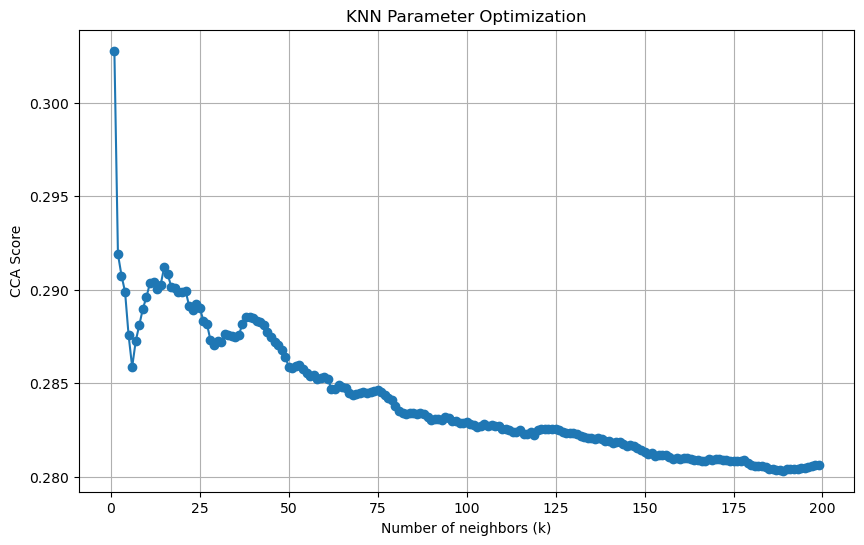


Optimal k: 1
Best score: 0.303

Feature correlations with target:
reaction_time_mean: 0.414
early_lick_rate: 0.388
finished_rate: 0.359
invalid_lick_ratio: 0.257
lick_consistency_mean_finished_trials: 0.251
double_dipping_rate_finished_trials: 0.227
foraging_eff: 0.205
reward_rate: 0.082

Tested 2 features, score: -0.187
Features: reaction_time_mean, early_lick_rate

Tested 3 features, score: -0.371
Features: reaction_time_mean, early_lick_rate, finished_rate

Tested 4 features, score: -0.213
Features: reaction_time_mean, early_lick_rate, finished_rate, invalid_lick_ratio

Tested 5 features, score: -0.149
Features: reaction_time_mean, early_lick_rate, finished_rate, invalid_lick_ratio, lick_consistency_mean_finished_trials

Tested 6 features, score: -0.141
Features: reaction_time_mean, early_lick_rate, finished_rate, invalid_lick_ratio, lick_consistency_mean_finished_trials, double_dipping_rate_finished_trials

Tested 7 features, score: -0.189
Features: reaction_time_mean, early_lick_

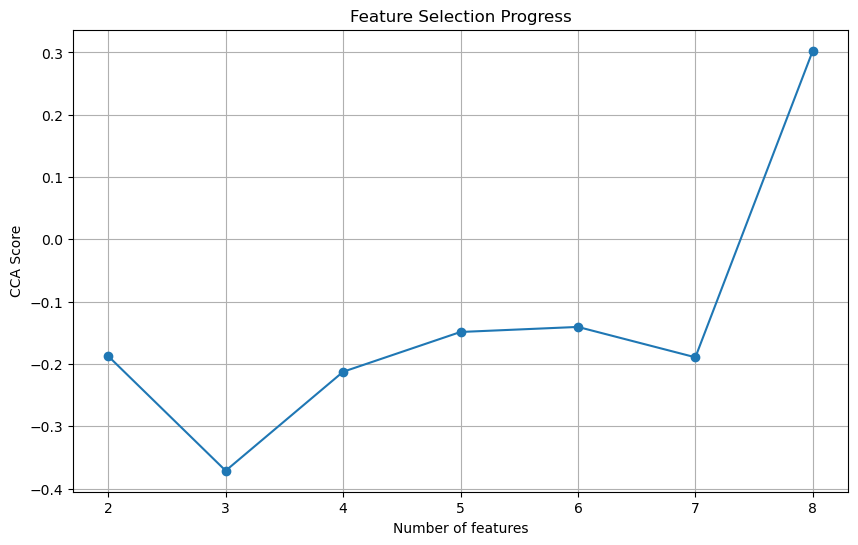


Best combination found:
Number of features: 8
Score: 0.303
Features: reaction_time_mean, early_lick_rate, finished_rate, invalid_lick_ratio, lick_consistency_mean_finished_trials, double_dipping_rate_finished_trials, foraging_eff, reward_rate

Final validation score: 0.303


In [46]:
# 1. First find optimal k with more detailed output
optimal_k, k_scores = find_optimal_k(df, feature_cols, target_col)

# 2. Clean data with optimal k
clean_df, _ = clean_numeric_features(
    df, 
    feature_cols, 
    nan_strategy='knn',
    knn_neighbors=optimal_k
)


# 3. Find best feature combination with more detailed analysis
best_features, best_score = optimal_compute_cca(
    clean_df, 
    feature_cols, 
    target_col, 
    min_features=2
)

# 4. Final CCA with optimized parameters
if best_features:
    df_cca, final_score = compute_cca(clean_df, best_features, target_col)
    print(f"\nFinal validation score: {final_score:.3f}")

In [47]:

def plot_cca_results(df, feature_cols, cca_score):

    fig = plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(df['canonical_X'], df['canonical_y'], alpha=0.5)
    plt.xlabel('Canonical Variable X')
    plt.ylabel('Canonical Variable Y')
    plt.title(f'Canonical Correlation\nScore: {cca_score:.3f}')
    
    loadings = []
    for feature in feature_cols:
        loading = df[f'{feature}_loading'].iloc[0]  # All rows have same loading
        loadings.append((feature, loading))
    

    loadings_df = pd.DataFrame(loadings, columns=['Feature', 'Loading'])
    loadings_df = loadings_df.sort_values('Loading', key=abs, ascending=True)
    
    plt.subplot(2, 2, 2)
    plt.barh(y=np.arange(len(loadings_df)), width=loadings_df['Loading'])
    plt.yticks(np.arange(len(loadings_df)), loadings_df['Feature'])
    plt.xlabel('Loading Value')
    plt.title('Feature Loadings')

    plt.subplot(2, 2, 3)
    sns.kdeplot(data=df['canonical_X'], label='Canonical X')
    sns.kdeplot(data=df['canonical_y'], label='Canonical Y')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Canonical Variables')
    plt.legend()
    

    top_features = loadings_df.tail(3)['Feature'].values
    
    plt.subplot(2, 2, 4)
    for feature in top_features:
        sns.kdeplot(data=df[feature], label=feature)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Top Features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

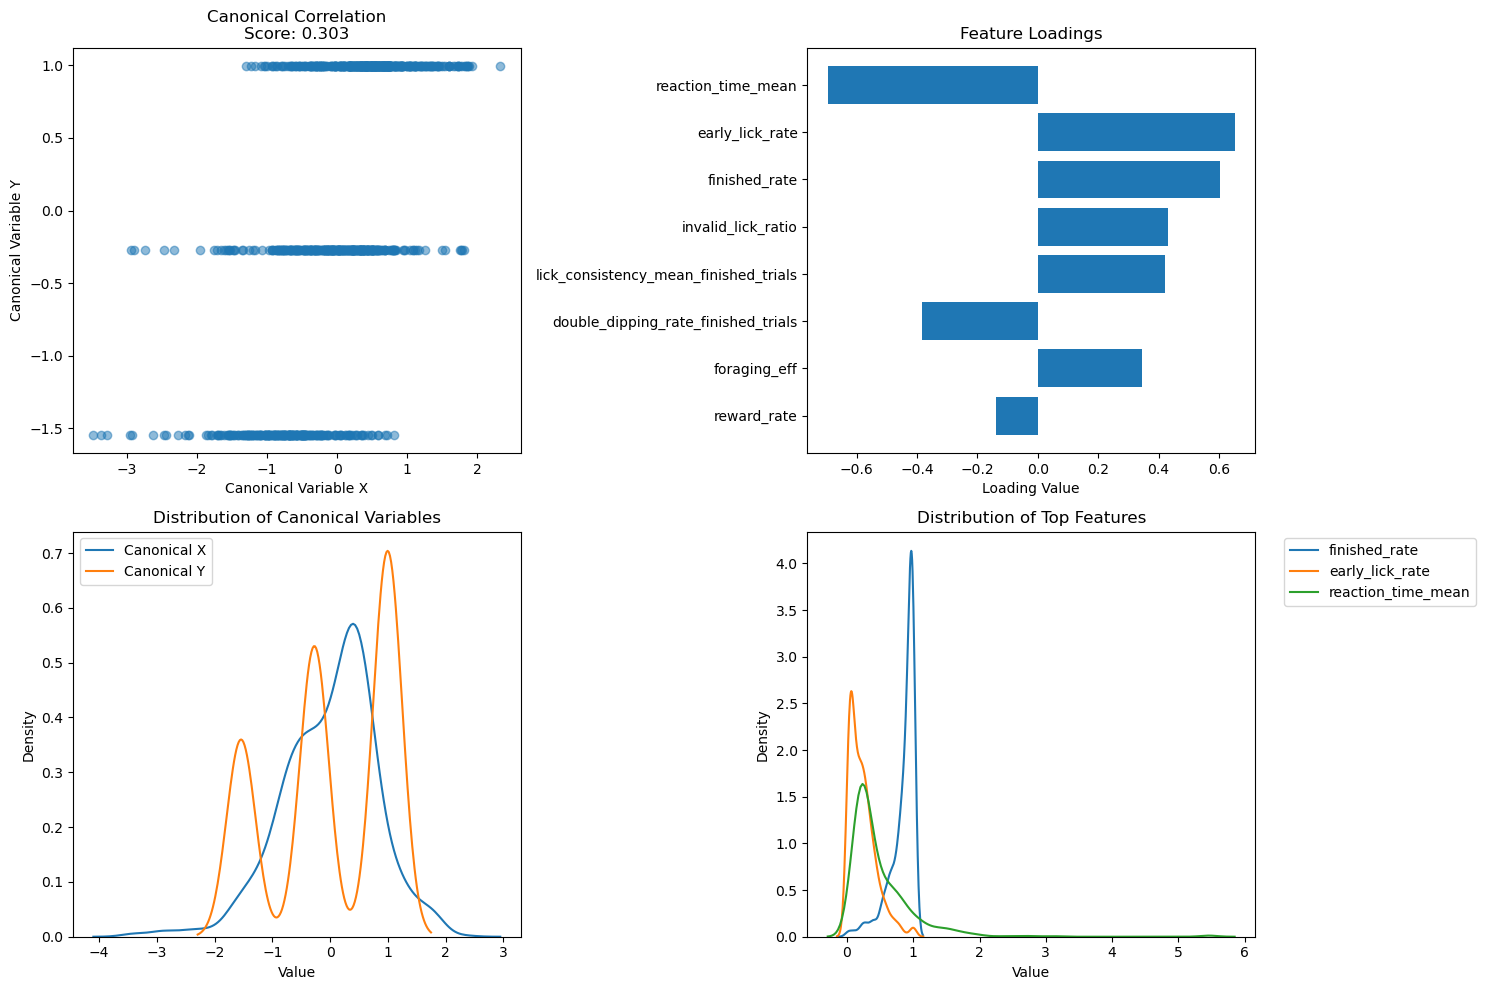

In [48]:
plot_cca_results(df_cca, feature_cols, final_score)

In [ ]:
# Next steps: DCCA, MIC, MIS, dCor, t-SNE, UMAP, PLS regression, GNN, spectral clustering, RF, XGboost, Auto-encoder, 

# 1. Visualize: t-sne, umap, pca - find non-linear pattern
# 2. correlation analysis: test for linear dependencies ie. MIC
# 3. model comparison? maybe DCCA , KCCA - compare performance with CV or other goodness of fit metrics

